# CS4055 Project Group 7

# Notebook 3 - Clustering

### Clustering Workflow

<img src="ClusteringWorkflow.png">

### K-Means Clustering

K-means Overview:

- The process begins with k centroids initialised at random.
- These centroids are used to assign points to its nearest cluster.
- The mean of all points within the cluster is then used to update the position of the centroids.
- The above steps are repeated until the values of the centroids stabilise.

===================================================================================================================

## 1 - Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn import cluster
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('./studentPor.csv')

===================================================================================================================

## 2 - Remove Outliers

In [3]:
Q1 = df['absences'].quantile(0.25)
Q3 = df['absences'].quantile(0.75)
IQR = Q3 - Q1

In [4]:
df['iqr']=(df['absences'] < (Q1 - 1.5 * IQR)) |(df['absences'] > (Q3 + 1.5 * IQR))

# a new df with outliers removed
df_data = df[df.iqr != True]
df_data = df_data.drop('iqr', axis=1)

===================================================================================================================

## 3 - Drop Target Attribute

In [5]:
df_data = df_data.drop('G3', axis=1)

===================================================================================================================

## 4 - Convert Categorical Attributes to Numeric

In [6]:
df_dummies = pd.get_dummies(df_data, drop_first=True, columns=['school',
                                                               'sex',
                                                               'address',
                                                               'famsize',
                                                               'Pstatus',
                                                               'Mjob',
                                                               'Fjob',
                                                               'reason',
                                                               'guardian',
                                                               'schoolsup',
                                                               'famsup',
                                                               'paid',
                                                               'activities',
                                                               'nursery',
                                                               'higher',
                                                               'internet',
                                                               'romantic'])

===================================================================================================================

## 5 - Convert Dataset to array

In [7]:
df_array = np.array(df_dummies, dtype=float)

===================================================================================================================

## 6 - Scale Dataset

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_array)

===================================================================================================================

## 7 - Find best value of K

To find our best value of K, we will use two methods: The Elbow Method, and The Silhouette Method.

The Elbow Method is more of a decision rule, while the Silhouette is a metric used for validation while clustering. Thus, it can be used in combination with the Elbow Method.

The Elbow Method and the Silhouette Method are not alternatives to each other for finding the optimal K. Rather, they are tools to be used together for a more confident decision.

### Elbow Method

For each k value, we will initialise k-means and use the inertia attribute to identify the within-cluster sum of squared distances (WSS) of samples to the nearest cluster centre.

As k increases, WSS tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning WSS equals zero.

It is a bit naive in its approach.

In [ ]:
Sum_of_squared_distances_elbow = []
K = range(1,10)
for k in K:
    km = cluster.KMeans(n_clusters=k, random_state=9)
    km = km.fit(df_scaled)
    Sum_of_squared_distances_elbow.append(km.inertia_)

If the plot looks like an arm, then the elbow point on the arm is optimal k.

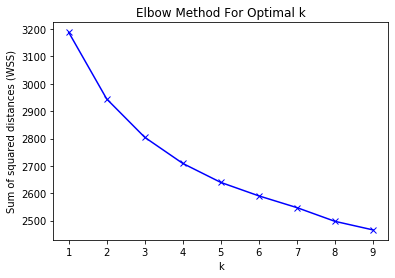

In [10]:
plt.plot(K, Sum_of_squared_distances_elbow, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances (WSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

__Conclusion__

There is no obvious elbow here. This may be because of the amount of features we have in our dataset.

We experimented with only using the features selected by Logistic Regression (which reduced the number of features from 32 down to 10) in our Predictive Models notebook. However, the results did not improve and did not give us a clear elbow either.

We can look at the Siloutte method for further information.

### Silhouette Method

The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

In [11]:
Sum_of_squared_distances_sil = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k, max_iter=9000).fit(df_scaled)
    labels = km.labels_
    Sum_of_squared_distances_sil.append(silhouette_score(df_scaled, labels, metric = 'euclidean'))

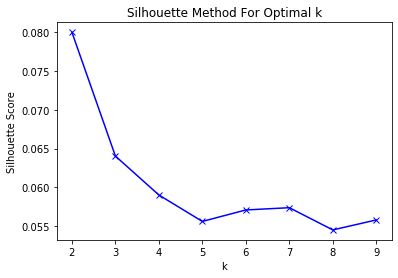

In [12]:
plt.plot(K, Sum_of_squared_distances_sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

__Conclusion__

This would suggest that the optimal value of __k is 2__. The silhouette method does not allow us to start from 1 which might have given us a clearer picture.

We will now try a __k-value of 2__ in our clustering and evaluate the results.

===================================================================================================================

## 8 - Apply K-Means Clustering

In [13]:
k = 2

In [14]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(df_scaled)

===================================================================================================================

## 9 - 2D Visualisation

### Scatterplot Function (to be used below for visualising a clustering)

In [15]:
colors = np.array(['orange', 'blue', 'lime', 'red', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    # plot the examples, i.e. the data points
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [16]:
df_scaled_and_centers = np.r_[df_scaled,clustered_data_sklearn.cluster_centers_]

### Apply multi-dimensional scaling (MDS) to project 

In [17]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(df_scaled_and_centers)

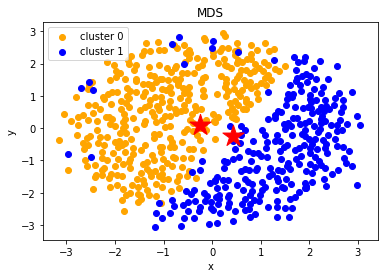

In [18]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

### Apply t-SNE to project 

In [19]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(df_scaled_and_centers)

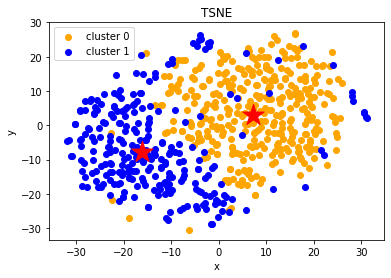

In [20]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

===================================================================================================================

## 10 - Cluster Analysis

__Add the cluster labels as an extra column in the original dataframe__

In [21]:
df_dummies['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df_dummies.index)

__Compute the mean value of all features for both clusters__

Note that we have artificially increased the number of features from 32 to 41 in step 4 (see explanation in step 4 in Predictive Models notebook)

In [22]:
# display first quarter of features
df_dummies.groupby('cluster').mean().iloc[:,0:13]

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
cluster,,,,,,,,,,,,,
0,16.797784,2.385042,2.080332,1.628809,1.916898,0.240997,3.941828,3.207756,3.216066,1.445983,2.252078,3.606648,3.307479
1,16.632959,2.685393,2.602996,1.494382,1.977528,0.187266,3.925094,3.131086,3.131086,1.528090,2.277154,3.464419,2.880150


In [23]:
# display second quarter of features
df_dummies.groupby('cluster').mean().iloc[:,13:24]

,G1,G2,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher
cluster,,,,,,,,,,,
0,11.351801,11.551247,0.335180,0.393352,0.667590,0.299169,0.858726,0.058172,0.506925,0.152355,0.074792
1,11.539326,11.685393,0.393258,0.430712,0.722846,0.280899,0.913858,0.101124,0.250936,0.284644,0.157303


In [24]:
# display third quarter of features
df_dummies.groupby('cluster').mean().iloc[:,24:33]

,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other
cluster,,,,,,,,,
0,0.000000,0.98615,0.000000,0.000000,0.246537,0.088643,0.224377,0.736842,0.080332
1,0.086142,0.00000,0.655431,0.127341,0.183521,0.146067,0.217228,0.659176,0.026217


In [25]:
# display fourth quarter of features
df_dummies.groupby('cluster').mean().iloc[:,33:]

,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
cluster,,,,,,,,
0,0.102493,0.581717,0.069252,0.451524,0.792244,0.889197,0.753463,0.365651
1,0.112360,0.651685,0.052434,0.539326,0.820225,0.910112,0.771536,0.363296


===================================================================================================================

## 11 - Conclusion

__Best Value of K__

We used both the Elbow Method and Silhouette Method to try and determine the best value for k based on a full feature set. However, the elbow method did not provide us with a definitive value. The Silhouette method did suggest that a value of 2 might be optimal.


__Clustering Algtorithm__

We used a k-Mean Clustering algorithm with a k value of 2. After experimenting with the hyper-parameters, we settled on an n_init value (number of times the algorithm will run with different centroid seeds, final results will be the best output of n_init consecutive runs in terms of inertia) of 100 and a max_iter value (max number of iterations of the k-means algorithm for a single run) of 300.


__Visualisation__

We appear to be getting a trade off between the two visualisation methods:
1. Using MDS gives us clearly distinct cluster groups, but positions the cluster center points very close together, and not central to their cluster.

2. Using t_SNE gives us less clearly defined cluster groups, however it does calculate the cluster center points centrally within each cluster.

Overall the clustering is evident 

__Cluster Analysis__

It is hard to gain any insight from this beacause we have so many features. There is not much difference in the mean value of any of the attributes between cluster 0 and cluster 1.

An interesting future study would be to apply PCA in order to reduce the dimensionality of our dataset. We could then check if the clustering shows an improvement and provides a clearer representation of the relationship between clusters and association of the dataset features.

===================================================================================================================